<a href="https://colab.research.google.com/github/rutujanemane/Liver-Tumor-Detection/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning


In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-10-07 16:38:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   205MB/s    in 0.4s    

2021-10-07 16:38:17 (205 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [127]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(200, 200, 3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(local_weights)
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 99, 99, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_658 (BatchN (None, 99, 99, 32)   96          conv2d_658[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 99, 99, 32)   0           batch_normalization_658[0][0]    
_______________________________________________________________________________________

In [128]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last Layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last Layer output shape:  (None, 10, 10, 768)


In [129]:
class MyCallbacks(tf.keras.callbacks.Callback):
    count=0
    def on_epoch_end(self, epoch, logs):

        if logs['accuracy'] > 0.99:
            self.count+=1
            if self.count==5:
                print('/nEarly Stopping the training as Validation Aaccuracy exceeded 99%!')
                self.model.stop_training = True
        else:
            self.count=0  

In [130]:
callbacks = MyCallbacks()

In [131]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)

# 128 neuron in the fully-connected layer
x=layers.Dense(128, activation='relu')(x)
# sigmoid activation
x=layers.Dense(1, activation=tf.nn.sigmoid)(x)


model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 99, 99, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_658 (BatchN (None, 99, 99, 32)   96          conv2d_658[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 99, 99, 32)   0           batch_normalization_658[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Now just load the data and train as you would

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,horizontal_flip=True,vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1/255)


train_dir = '/content/drive/MyDrive/dataset_for_detection/train_dir/'
val_dir='/content/drive/MyDrive/dataset_for_detection/val_dir/'

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        # Specify the classes explicitly
        classes = ['Normal','Tumor'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='binary')

val_generator=val_datagen.flow_from_directory(
        val_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        # Specify the classes explicitly
        classes = ['Normal','Tumor'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='binary')


Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [134]:
total_sample=train_generator.n

n_epochs = 100

history = model.fit(
        train_generator, 
        validation_data=val_generator,  
        epochs=n_epochs,
        verbose=1, callbacks=[callbacks])

# model.save('model.h5')

import numpy as np
from keras.preprocessing import image

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.7400 - accuracy: 0.3667 - val_loss: 2.0426 - val_accuracy: 0.6667
Epoch 2/100
1/1 [==============================] - 1s 756ms/step - loss: 1.7854 - accuracy: 0.6667 - val_loss: 0.5581 - val_accuracy: 0.5667
Epoch 3/100
1/1 [==============================] - 1s 760ms/step - loss: 0.4963 - accuracy: 0.7333 - val_loss: 0.5150 - val_accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 1s 732ms/step - loss: 0.3002 - accuracy: 0.7667 - val_loss: 0.1673 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 1s 725ms/step - loss: 0.1018 - accuracy: 1.0000 - val_loss: 0.1657 - val_accuracy: 0.9667
Epoch 6/100
1/1 [==============================] - 1s 727ms/step - loss: 0.0674 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 1s 739ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.0718 - val_accuracy: 1.0000
Epoch 8/100
1/

In [135]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

In [136]:
import matplotlib.pyplot as plt

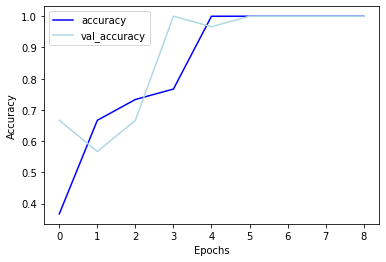

Accuracy:  1.0
Validation Accuracy:  1.0


In [137]:
plt.plot(acc,'b', label='accuracy')
plt.plot(val_acc,'lightblue', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ",history.history['val_accuracy'][-1])

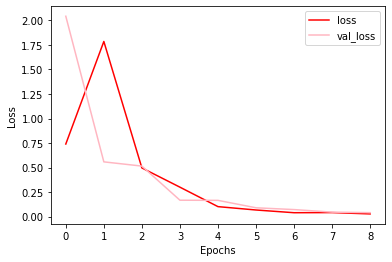

Loss: 0.0275325495749712
Validation Loss: 0.040274880826473236


In [138]:
plt.plot(loss,'r', label='loss')
plt.plot(val_loss,'lightpink', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Loss:",history.history['loss'][-1])
print("Validation Loss:",history.history['val_loss'][-1])